# Decision Tree and Random Forest

In [11]:
import pandas as pd
import numpy as np

In [12]:
data = {
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
    'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'High', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Wind' : ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Strong'],
    'Play' : ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
}

In [13]:
df = pd.DataFrame(data)
print(df)

     Outlook Temperature Humidity    Wind Play
0      Sunny         Hot     High    Weak   No
1      Sunny         Hot     High  Strong   No
2   Overcast         Hot     High    Weak  Yes
3       Rain        Mild     High    Weak  Yes
4       Rain        Cool   Normal    Weak  Yes
5       Rain        Cool   Normal  Strong   No
6   Overcast        Cool   Normal  Strong  Yes
7      Sunny        Mild     High    Weak   No
8      Sunny        Cool   Normal    Weak  Yes
9       Rain        Mild   Normal    Weak  Yes
10     Sunny        Mild   Normal  Strong  Yes
11  Overcast        Mild     High  Strong  Yes
12  Overcast        High   Normal    Weak  Yes
13      Rain        Mild     High  Strong   No


# ID3 Classifier without using libraries

In [14]:
def entropy(values):
    value_count = np.unique(values, return_counts=True)[1]
    value_prob = value_count / float(np.sum(value_count))
    value_prob_log = np.log2(value_prob)
    return -np.dot(value_prob, value_prob_log)


class Node:
    def __init__(self,index = [], entropy = 0, depth = 0):
        self.index = index 
        self.child = [] 
        self.entropy = entropy
        self.depth = depth
        self.attribute = None 
        self.attribute_value = [] 
        self.label = None 

In [15]:
x = np.arange(0, 12).reshape(3,-1)

In [16]:
class ID3Algorithm:
    def __init__(self, samples_cutoff = 2, min_info_gain = 1e-4, max_depth = 4):
        self.samples_cutoff = samples_cutoff
        self.min_gain = min_info_gain
        self.max_depth = max_depth
        self.root = None
        

    def _entropy(self,index_list):
        if len(index_list) == 0: return 0
        class_value = self.target[index_list]
        return entropy(class_value)
    

    def fit(self, data, target, attributes):
        self.data = data
        self.target = target
        self.attributes = attributes
        self.data_list = np.arange(len(data))
        self.attribute_list = np.arange(len(data[0]))
        self.root = self.build_tree(0,self.data_list, 
                               entropy=entropy(self.target[self.data_list]),
                               attribute_list = self.attribute_list,
                               depth = 0)
        

    def build_tree(self,indent, data_index, entropy, attribute_list, depth):
        node = Node(data_index, entropy, depth)
        value_count = np.unique(self.target[data_index], return_counts=True)[0]
        if (len(value_count) == 1):
            node.label = value_count[0][0]
            return node
        
        elif (len(data_index) < self.samples_cutoff or depth == self.max_depth or len(attribute_list) == 0):
            max_index= np.argmax(value_count[1])
            node.label = value_count[0][max_index]
            return node
        
        attributes_entropy = []
        att_len = len(attribute_list)
        for i in range(att_len): 
            attribute_total_entropy = 0
            attribute_values_count = np.unique(self.data[data_index, attribute_list[i]], return_counts=True)
            attribute_len = len(attribute_values_count[0])
            num_of_data = np.sum(attribute_values_count[1])
            for j in range(attribute_len):
                attribute_value_index = []
                for k in range(len(data_index)):
                    if (self.data[data_index[k]][attribute_list[i]] == attribute_values_count[0][j]): 
                        attribute_value_index.append(data_index[k])
                attribute_value_entropy = self._entropy(attribute_value_index)
                attribute_total_entropy += attribute_value_entropy*float(attribute_values_count[1][j] / num_of_data)
            attributes_entropy.append(attribute_total_entropy) #check
        attributes_info_gain = entropy - attributes_entropy # check
        attribute_index_with_most_gain = np.argmax(attributes_info_gain) # check
        attribute_value_with_most_gain = attribute_list[attribute_index_with_most_gain] # check

        if (attributes_info_gain[attribute_index_with_most_gain] < self.min_gain):
            max_index= np.argmax(value_count[1])
            print(value_count[0][max_index])
            node.label = value_count[0][max_index]
            return node
        
        node.attribute = attribute_value_with_most_gain
        node.attribute_value = np.unique(self.data[data_index, attribute_value_with_most_gain])
        attribute_list_filter = np.delete(attribute_list, attribute_index_with_most_gain)
        for i in range(len(node.attribute_value)):
            new_data_index = []
            for j in range(len(data_index)):
                if (self.data[data_index[j]][node.attribute] == node.attribute_value[i]):
                    new_data_index.append(data_index[j])
            new_entropy = self._entropy(new_data_index)
            new_attribute_list = attribute_list_filter.copy()
            child_node = self.build_tree(indent + 4, new_data_index, new_entropy, new_attribute_list,depth+1)
            node.child.append(child_node)
        return node 
    

    def predict(self, new_data):
        npoints = len(new_data)
        labels = [None]*npoints
        for n in range(npoints):
            x = new_data[n] # one point 
            node = self.root
            while node.child: 
                attribute = node.attribute
                idx = 0
                for i in range(len(node.attribute_value)):
                    if (x[attribute] == node.attribute_value[i]):
                        idx = i
                        break
                node = node.child[idx]
            labels[n] = node.label

        return labels

In [17]:
X = np.array(df.iloc[:, :-1])
y = np.array(df.iloc[:, -1])
for i in range(len(y)):
    if (y[i] == 'Yes'):
        y[i] = 'Yes'
    else:
        y[i] = 'No'


attributes = np.array(df.columns[:-1])
attributes

dtm = ID3Algorithm()
dtm.fit(X, y, attributes)
pred = dtm.predict(X)

print("Actual Values in the dataset: ")
print(np.array(pred, dtype='object'))
print("\n\nPredicted Values in the Dataset: ")
print(y)

Actual Values in the dataset: 
['N' 'N' 'Y' 'Y' 'Y' 'N' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'N']


Predicted Values in the Dataset: 
['No' 'No' 'Yes' 'Yes' 'Yes' 'No' 'Yes' 'No' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'No']


# Random Forest Classifier without using libraries

In [18]:
for col in df.columns:
    df[col] = df[col].astype('category').cat.codes

data_array = df.to_numpy()
print(data_array)

[[2 2 0 1 0]
 [2 2 0 0 0]
 [0 2 0 1 1]
 [1 3 0 1 1]
 [1 0 1 1 1]
 [1 0 1 0 0]
 [0 0 1 0 1]
 [2 3 0 1 0]
 [2 0 1 1 1]
 [1 3 1 1 1]
 [2 3 1 0 1]
 [0 3 0 0 1]
 [0 1 1 1 1]
 [1 3 0 0 0]]


In [58]:
from collections import Counter

def entropy(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities))

def information_gain(X, y, feature_idx):
    total_entropy = entropy(y)
    values, counts = np.unique(X[:, feature_idx], return_counts=True)
    
    weighted_entropy = 0
    for v, c in zip(values, counts):
        subset_y = y[X[:, feature_idx] == v]
        weighted_entropy += (c / len(y)) * entropy(subset_y)
    
    return total_entropy - weighted_entropy

def build_tree(X, y, features):
    if len(set(y)) == 1:
        return y[0]
    
    if len(features) == 0:
        return Counter(y).most_common(1)[0][0]

    # Calculate IG for each feature
    gains = [information_gain(X, y, i) for i in features]
    best_feature = features[np.argmax(gains)]
    
    tree = {best_feature: {}}
    
    for value in np.unique(X[:, best_feature]):
        subset_idx = X[:, best_feature] == value
        subtree = build_tree(X[subset_idx], y[subset_idx], [f for f in features if f != best_feature])
        tree[best_feature][value] = subtree
    
    return tree

def predict(tree, sample):
    if not isinstance(tree, dict):
        return tree
    
    feature = list(tree.keys())[0]
    feature_value = sample[feature]
    
    if feature_value in tree[feature]:
        return predict(tree[feature][feature_value], sample)
    else:
        return Counter(tree[feature].values()).most_common(1)[0][0]

def random_forest(X, y, num_trees=3, sample_size=None):
    if sample_size is None:
        sample_size = len(y)
    
    trees = []
    for _ in range(num_trees):
        indices = np.random.choice(len(y), size=sample_size, replace=True)
        X_sample, y_sample = X[indices], y[indices]
        features = np.random.choice(range(X.shape[1]), size=int(np.sqrt(X.shape[1])), replace=False)
        tree = build_tree(X_sample, y_sample, features)
        trees.append(tree)
    
    return trees

def predict_forest(forest, sample):
    predictions = [predict(tree, sample) for tree in forest]
    return Counter(predictions).most_common(1)[0][0]

def evaluate_accuracy(forest, X, y):
    predictions = [predict_forest(forest, row) for row in X]
    correct = sum(y == predictions)
    return correct / len(y)

X, y = data_array[:, :-1], data_array[:, -1]
forest = random_forest(X, y, num_trees=3)

predictions = [predict_forest(forest, row) for row in X]

accuracy = evaluate_accuracy(forest, X, y)

print("\nEntropy value for Target Variable:")
print(entropy(y))

print("\nInformation Gain for each feature:")
for i in range(X.shape[1]):
    print(f"Feature {i}: Information Gain = {information_gain(X, y, i):.4f}")

print("\nRandom Forest Decision Trees: ")
for i, tree in enumerate(forest):
    print(f"Tree {i+1}: {tree}")

print("\nActual vs. Predicted Values:")
for actual, pred in zip(y, predictions):
    print(f"Actual: {actual}, \tPredicted: {pred}")

print(f"\nRandom Forest Accuracy: {accuracy * 100:.2f}%")



Entropy value for Target Variable:
0.9402859586706311

Information Gain for each feature:
Feature 0: Information Gain = 0.2467
Feature 1: Information Gain = 0.1182
Feature 2: Information Gain = 0.1518
Feature 3: Information Gain = 0.0481

Random Forest Decision Trees: 
Tree 1: {np.int64(0): {np.int8(0): np.int8(1), np.int8(1): {np.int64(3): {np.int8(0): np.int8(0), np.int8(1): np.int8(1)}}, np.int8(2): {np.int64(3): {np.int8(0): np.int8(0), np.int8(1): np.int8(1)}}}}
Tree 2: {np.int64(2): {np.int8(0): {np.int64(3): {np.int8(0): np.int8(0), np.int8(1): np.int8(0)}}, np.int8(1): {np.int64(3): {np.int8(0): np.int8(1), np.int8(1): np.int8(1)}}}}
Tree 3: {np.int64(0): {np.int8(0): np.int8(1), np.int8(1): np.int8(1), np.int8(2): {np.int64(3): {np.int8(0): np.int8(0), np.int8(1): np.int8(0)}}}}

Actual vs. Predicted Values:
Actual: 0, 	Predicted: 0
Actual: 0, 	Predicted: 0
Actual: 1, 	Predicted: 1
Actual: 1, 	Predicted: 1
Actual: 1, 	Predicted: 1
Actual: 0, 	Predicted: 1
Actual: 1, 	Predicte

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

actual_values = np.array(y)
predicted_values = np.array(predictions)

cm = confusion_matrix(actual_values, predicted_values)

print(cm)

[[2 3]
 [0 9]]


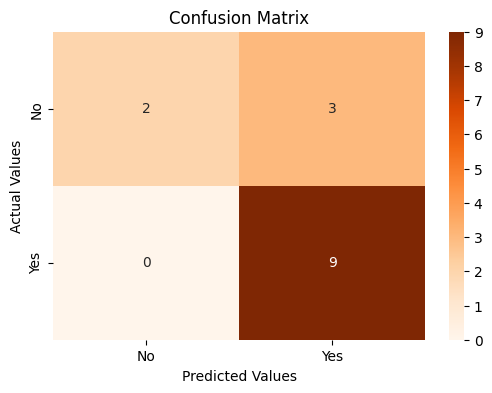

In [26]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix")
plt.show()

# Data Visualization of the Dataset

C:\Users\student\AppData\Local\Temp\ipykernel_16380\3020235286.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['Play'], palette='Oranges')


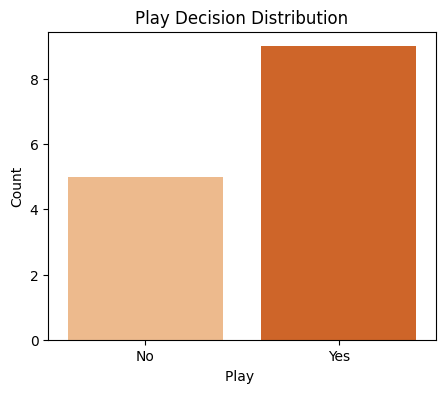

In [22]:
plt.figure(figsize=(5, 4))
sns.countplot(x=data['Play'], palette='Oranges')
plt.title("Play Decision Distribution")
plt.xlabel("Play ")
plt.ylabel("Count")
plt.show()


C:\Users\student\AppData\Local\Temp\ipykernel_16380\3501236966.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data[feature], ax=axes[row, col], palette=colors[i])
C:\Users\student\AppData\Local\Temp\ipykernel_16380\3501236966.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data[feature], ax=axes[row, col], palette=colors[i])
C:\Users\student\AppData\Local\Temp\ipykernel_16380\3501236966.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data[feature], ax=axes[row, col], palette=colors[i])
C:\Users\student\AppData\Local\

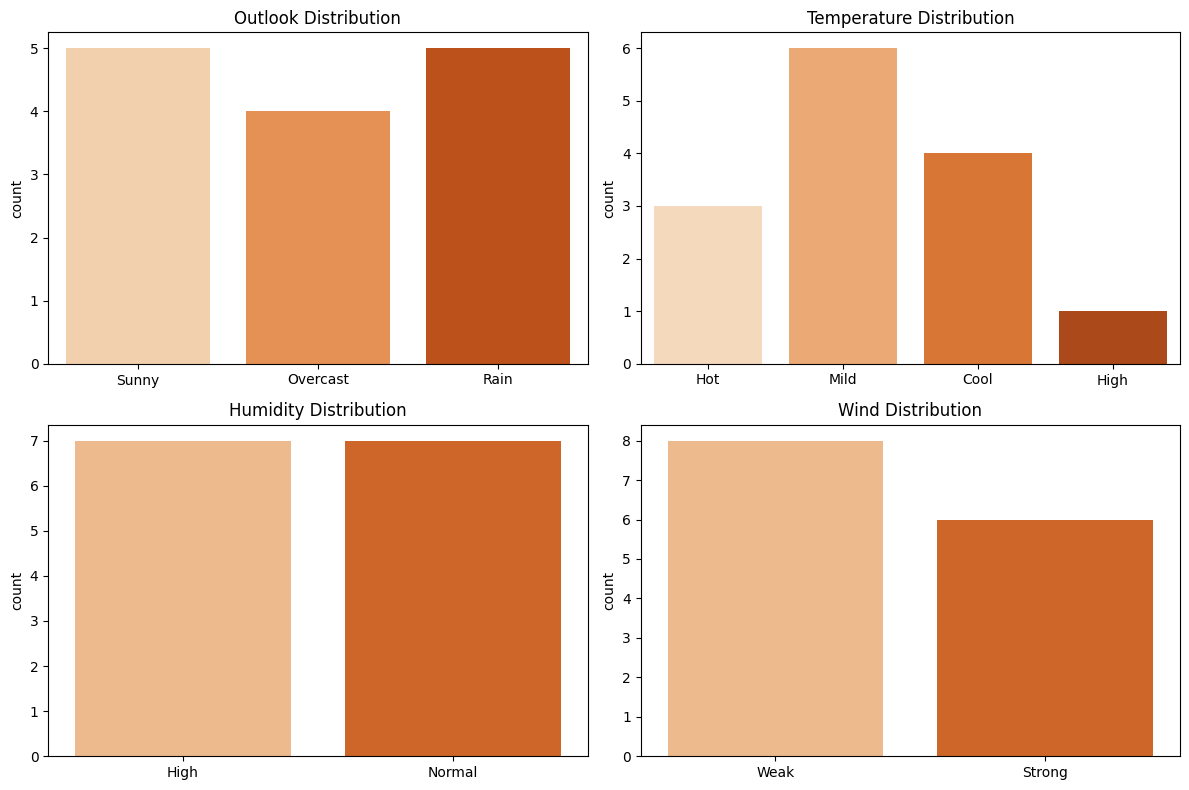

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

features = ['Outlook', 'Temperature', 'Humidity', 'Wind']
colors = ['Oranges', 'Oranges', 'Oranges', 'Oranges']

for i, feature in enumerate(features):
    row, col = i // 2, i % 2
    sns.countplot(x=data[feature], ax=axes[row, col], palette=colors[i])
    axes[row, col].set_title(f"{feature} Distribution")

plt.tight_layout()
plt.show()


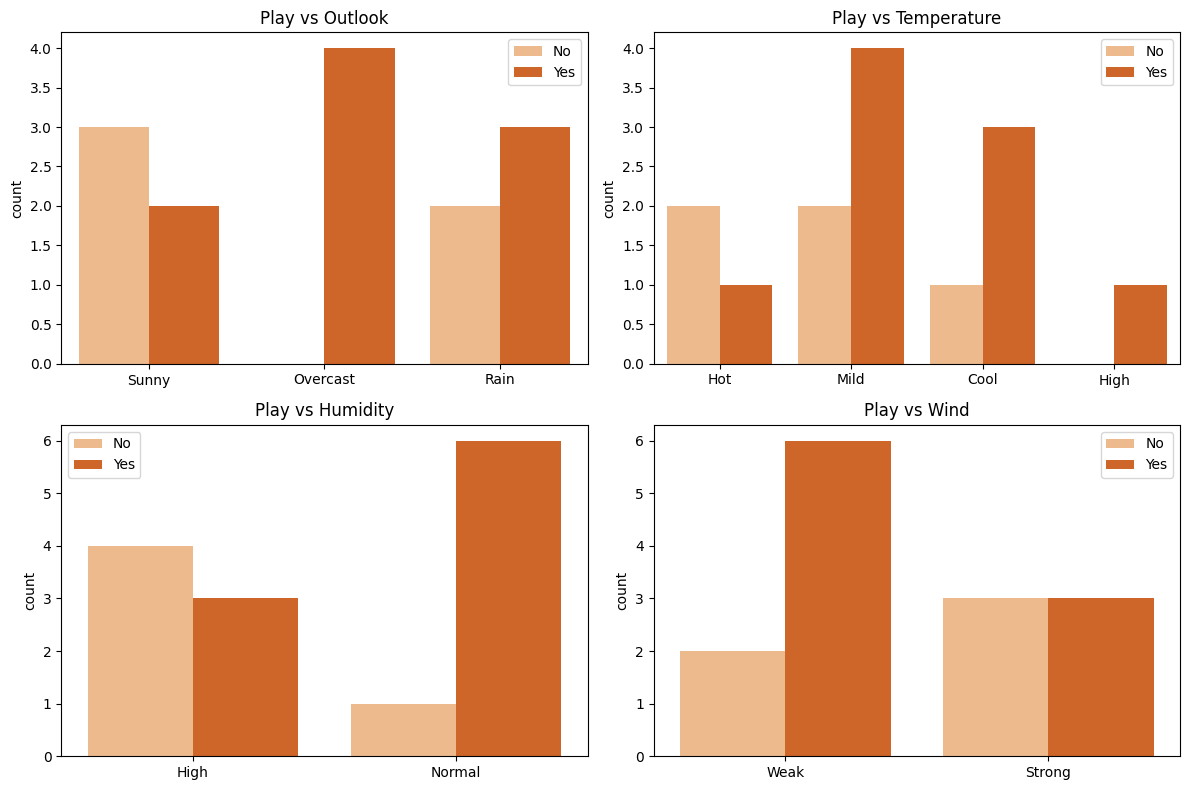

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, feature in enumerate(features):
    row, col = i // 2, i % 2
    sns.countplot(x=data[feature], hue=data['Play'], ax=axes[row, col], palette="Oranges")
    axes[row, col].set_title(f"Play vs {feature}")

plt.tight_layout()
plt.show()


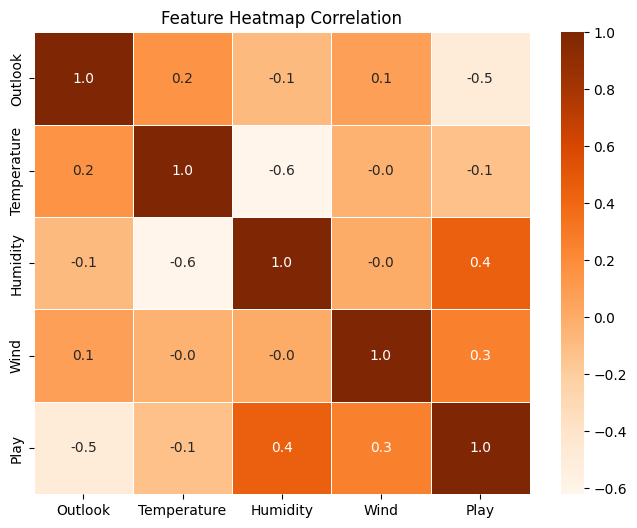

In [59]:
df_corr = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr, annot=True, cmap="Oranges", fmt=".1f", linewidths=.5)
plt.title("Feature Heatmap Correlation")
plt.show()